In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import joblib 
import time

from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.losses import Huber
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsolutePercentageError
from tensorflow.keras.optimizers import Adam 

from keras.saving import register_keras_serializable

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from scipy.stats import pearsonr

In [2]:
df = pd.read_csv('dataset/PS_001_solarstation.csv', sep=',', decimal='.')  
df

,ambient_temperature_celsius,battery_voltage,datetime,document_count_ambient_temperature_celsius,document_count_battery_voltage,document_count_ghi_irradiance_wm2,document_count_gri_irradiance_wm2,document_count_panel_temperature_celsius,document_count_poa_irradiance_wm2,document_count_precipitation_accumulated_mm,...,interpolated_keys_tracker_albedo_index,interpolated_keys_wind_direction_degrees,interpolated_keys_wind_speed_ms,panel_temperature_celsius,poa_irradiance_wm2,precipitation_accumulated_mm,ps_id,tracker_albedo_index,wind_direction_degrees,wind_speed_ms
0,NaN,NaN,2024-03-26T00:00:00Z,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,PS_001,NaN,NaN,NaN
1,NaN,NaN,2024-03-26T00:15:00Z,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,PS_001,NaN,NaN,NaN
2,NaN,NaN,2024-03-26T00:30:00Z,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,PS_001,NaN,NaN,NaN
3,NaN,NaN,2024-03-26T00:45:00Z,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,PS_001,NaN,NaN,NaN
4,NaN,NaN,2024-03-26T01:00:00Z,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,PS_001,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42331,NaN,NaN,2025-06-09T22:45:00Z,0,0,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,529.600037,PS_001,NaN,NaN,NaN
42332,NaN,NaN,2025-06-09T23:00:00Z,0,0,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,529.600037,PS_001,NaN,NaN,NaN
42333,NaN,NaN,2025-06-09T23:15:00Z,0,0,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,529.600037,PS_001,NaN,NaN,NaN
42334,NaN,NaN,2025-06-09T23:30:00Z,0,0,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,529.600037,PS_001,NaN,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42336 entries, 0 to 42335
Data columns (total 31 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   ambient_temperature_celsius                    41004 non-null  float64
 1   battery_voltage                                41001 non-null  float64
 2   datetime                                       42336 non-null  object 
 3   document_count_ambient_temperature_celsius     42336 non-null  int64  
 4   document_count_battery_voltage                 42336 non-null  int64  
 5   document_count_ghi_irradiance_wm2              42336 non-null  int64  
 6   document_count_gri_irradiance_wm2              42336 non-null  int64  
 7   document_count_panel_temperature_celsius       42336 non-null  int64  
 8   document_count_poa_irradiance_wm2              42336 non-null  int64  
 9   document_count_precipitation_accumulated_mm    423

In [4]:
df.isnull().sum()

ambient_temperature_celsius                       1332
battery_voltage                                   1335
datetime                                             0
document_count_ambient_temperature_celsius           0
document_count_battery_voltage                       0
document_count_ghi_irradiance_wm2                    0
document_count_gri_irradiance_wm2                    0
document_count_panel_temperature_celsius             0
document_count_poa_irradiance_wm2                    0
document_count_precipitation_accumulated_mm          0
document_count_tracker_albedo_index                  0
document_count_wind_direction_degrees                0
document_count_wind_speed_ms                         0
ghi_irradiance_wm2                                1317
gri_irradiance_wm2                                1324
interpolated_keys_ambient_temperature_celsius    42279
interpolated_keys_battery_voltage                42280
interpolated_keys_ghi_irradiance_wm2             42278
interpolat

In [5]:
df.drop(['interpolated_keys_ambient_temperature_celsius', 'interpolated_keys_battery_voltage', 'interpolated_keys_ghi_irradiance_wm2', 'interpolated_keys_gri_irradiance_wm2', 'interpolated_keys_panel_temperature_celsius', 'interpolated_keys_tracker_albedo_index', 'interpolated_keys_poa_irradiance_wm2', 'interpolated_keys_wind_direction_degrees', 'interpolated_keys_wind_speed_ms'], axis=1, inplace=True)
df.drop(['ps_id','document_count_ambient_temperature_celsius', 'document_count_battery_voltage', 'document_count_ghi_irradiance_wm2', 'document_count_gri_irradiance_wm2', 'document_count_panel_temperature_celsius', 'document_count_poa_irradiance_wm2', 'document_count_precipitation_accumulated_mm', 'document_count_tracker_albedo_index', 'document_count_wind_direction_degrees', 'document_count_wind_speed_ms'], axis= 1, inplace=True)

In [6]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42336 entries, 0 to 42335
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ambient_temperature_celsius   41004 non-null  float64
 1   battery_voltage               41001 non-null  float64
 2   datetime                      42336 non-null  object 
 3   ghi_irradiance_wm2            41019 non-null  float64
 4   gri_irradiance_wm2            41012 non-null  float64
 5   panel_temperature_celsius     41000 non-null  float64
 6   poa_irradiance_wm2            41014 non-null  float64
 7   precipitation_accumulated_mm  42265 non-null  float64
 8   tracker_albedo_index          40980 non-null  float64
 9   wind_direction_degrees        40998 non-null  float64
 10  wind_speed_ms                 40995 non-null  float64
dtypes: float64(10), object(1)
memory usage: 3.6+ MB


In [7]:
# pastikan kolom datetime jadi datetime type
df['datetime'] = pd.to_datetime(df['datetime'])

# set datetime sebagai index
df = df.set_index('datetime').sort_index()

In [8]:
print("Range data asli:")
print(df.index.min(), " → ", df.index.max())

print("\nJumlah baris asli:", len(df))

Range data asli:
2024-03-26 00:00:00+00:00  →  2025-06-09 23:45:00+00:00

Jumlah baris asli: 42336


In [9]:
# helper circular mean utk arah angin
def circular_mean_deg(x):
    x = x.dropna()
    if x.empty:
        return np.nan
    rad = np.deg2rad(x.values)
    return np.mod(np.rad2deg(np.arctan2(np.sin(rad).mean(), np.cos(rad).mean())), 360.0)

hourly = pd.DataFrame()
hourly['ambient_temperature_celsius'] = df['ambient_temperature_celsius'].resample('1h').agg('mean')
hourly['battery_voltage'] = df['battery_voltage'].resample('1h').agg('mean')
hourly['ghi_irradiance_wm2'] = df['ghi_irradiance_wm2'].resample('1h').agg('mean')
hourly['gri_irradiance_wm2'] = df['gri_irradiance_wm2'].resample('1h').agg('mean')
hourly['panel_temperature_celsius'] = df['panel_temperature_celsius'].resample('1h').agg('mean')
hourly['poa_irradiance_wm2'] = df['poa_irradiance_wm2'].resample('1h').agg('mean')
hourly['tracker_albedo_index'] = df['tracker_albedo_index'].resample('1h').agg('mean')

# precipitation pakai sum
hourly['precipitation_accumulated_mm'] = df['precipitation_accumulated_mm'].resample('1h').sum(min_count=1)

# wind speed pakai mean
hourly['wind_speed_ms'] = df['wind_speed_ms'].resample('1h').agg('mean')

# wind direction pakai circular mean
hourly['wind_direction_degrees'] = df['wind_direction_degrees'].resample('1h').apply(circular_mean_deg)

df = hourly
print(df.head())


                           ambient_temperature_celsius  battery_voltage  \
datetime                                                                  
2024-03-26 00:00:00+00:00                          NaN              NaN   
2024-03-26 01:00:00+00:00                          NaN              NaN   
2024-03-26 02:00:00+00:00                          NaN              NaN   
2024-03-26 03:00:00+00:00                          NaN              NaN   
2024-03-26 04:00:00+00:00                          NaN              NaN   

                           ghi_irradiance_wm2  gri_irradiance_wm2  \
datetime                                                            
2024-03-26 00:00:00+00:00                 NaN                 NaN   
2024-03-26 01:00:00+00:00                 NaN                 NaN   
2024-03-26 02:00:00+00:00                 NaN                 NaN   
2024-03-26 03:00:00+00:00                 NaN                 NaN   
2024-03-26 04:00:00+00:00                 NaN               

In [10]:
print("Jumlah baris resample:", len(df))
print("Jumlah baris kosong semua kolom:", (df.isna().all(axis=1)).sum())

Jumlah baris resample: 10584
Jumlah baris kosong semua kolom: 17


In [11]:
df = df.dropna(how='all')
print("Jumlah baris setelah dropna:", len(df))

Jumlah baris setelah dropna: 10567


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10567 entries, 2024-03-26 17:00:00+00:00 to 2025-06-09 23:00:00+00:00
Freq: h
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ambient_temperature_celsius   10284 non-null  float64
 1   battery_voltage               10284 non-null  float64
 2   ghi_irradiance_wm2            10286 non-null  float64
 3   gri_irradiance_wm2            10285 non-null  float64
 4   panel_temperature_celsius     10284 non-null  float64
 5   poa_irradiance_wm2            10285 non-null  float64
 6   tracker_albedo_index          10279 non-null  float64
 7   precipitation_accumulated_mm  10567 non-null  float64
 8   wind_speed_ms                 10284 non-null  float64
 9   wind_direction_degrees        10284 non-null  float64
dtypes: float64(10)
memory usage: 908.1 KB


In [13]:
df.isnull().sum()

ambient_temperature_celsius     283
battery_voltage                 283
ghi_irradiance_wm2              281
gri_irradiance_wm2              282
panel_temperature_celsius       283
poa_irradiance_wm2              282
tracker_albedo_index            288
precipitation_accumulated_mm      0
wind_speed_ms                   283
wind_direction_degrees          283
dtype: int64

In [14]:
# cek dulu berapa NaN sebelum diisi
print("Missing values sebelum interpolasi:")
print(df.isnull().sum())

# interpolasi berbasis waktu
df_interpolated = df.interpolate(method='time', limit_direction='both')

# cek lagi sesudah diisi
print("\nMissing values sesudah interpolasi:")
print(df_interpolated.isnull().sum())


Missing values sebelum interpolasi:
ambient_temperature_celsius     283
battery_voltage                 283
ghi_irradiance_wm2              281
gri_irradiance_wm2              282
panel_temperature_celsius       283
poa_irradiance_wm2              282
tracker_albedo_index            288
precipitation_accumulated_mm      0
wind_speed_ms                   283
wind_direction_degrees          283
dtype: int64

Missing values sesudah interpolasi:
ambient_temperature_celsius     0
battery_voltage                 0
ghi_irradiance_wm2              0
gri_irradiance_wm2              0
panel_temperature_celsius       0
poa_irradiance_wm2              0
tracker_albedo_index            0
precipitation_accumulated_mm    0
wind_speed_ms                   0
wind_direction_degrees          0
dtype: int64


In [15]:
df = df_interpolated
df

,ambient_temperature_celsius,battery_voltage,ghi_irradiance_wm2,gri_irradiance_wm2,panel_temperature_celsius,poa_irradiance_wm2,tracker_albedo_index,precipitation_accumulated_mm,wind_speed_ms,wind_direction_degrees
datetime,,,,,,,,,,
2024-03-26 17:00:00+00:00,22.575969,13.789027,54.818186,10.414630,22.545728,53.648173,17.076170,1214.400024,1.362476,92.374201
2024-03-26 18:00:00+00:00,20.679402,13.788328,63.069766,16.497788,20.111486,51.266562,31.341852,2542.000122,1.342064,118.546065
2024-03-26 19:00:00+00:00,21.340098,13.787549,77.639489,20.848432,20.673546,63.116177,33.324386,2585.200073,0.665487,164.824822
2024-03-26 20:00:00+00:00,21.166663,13.786799,23.998765,3.949523,20.603996,24.222248,13.610682,2585.600098,0.626970,218.090017
2024-03-26 21:00:00+00:00,20.861671,13.786258,1.479742,0.082032,20.090568,1.353761,22.379807,2585.600098,0.730051,207.084389
...,...,...,...,...,...,...,...,...,...,...
2025-06-09 19:00:00+00:00,21.260540,13.796218,139.417318,22.909915,25.984689,156.539533,14.583083,2118.400146,2.149233,78.446299
2025-06-09 20:00:00+00:00,21.260540,13.796218,139.417318,22.909915,25.984689,156.539533,14.583083,2118.400146,2.149233,78.446299
2025-06-09 21:00:00+00:00,21.260540,13.796218,139.417318,22.909915,25.984689,156.539533,14.583083,2118.400146,2.149233,78.446299


In [16]:
df.isnull().sum()

ambient_temperature_celsius     0
battery_voltage                 0
ghi_irradiance_wm2              0
gri_irradiance_wm2              0
panel_temperature_celsius       0
poa_irradiance_wm2              0
tracker_albedo_index            0
precipitation_accumulated_mm    0
wind_speed_ms                   0
wind_direction_degrees          0
dtype: int64

In [17]:
correlation = df.corr(method='pearson')["panel_temperature_celsius"].sort_values(ascending=False)
correlation

panel_temperature_celsius       1.000000
gri_irradiance_wm2              0.882138
poa_irradiance_wm2              0.879077
ghi_irradiance_wm2              0.875364
ambient_temperature_celsius     0.862822
wind_speed_ms                   0.235569
tracker_albedo_index           -0.019225
precipitation_accumulated_mm   -0.047862
wind_direction_degrees         -0.329638
battery_voltage                -0.592549
Name: panel_temperature_celsius, dtype: float64

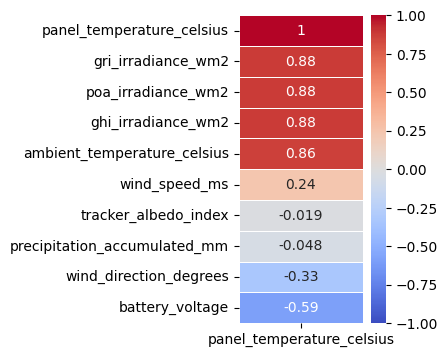

In [18]:
plt.figure(figsize=(2, 4))
sns.heatmap(correlation.to_frame(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar=True, linewidths=0.5, linecolor='white')
plt.show()

In [19]:
df.drop(['tracker_albedo_index', 'precipitation_accumulated_mm', 'wind_direction_degrees', 'battery_voltage'], axis=1, inplace=True)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10567 entries, 2024-03-26 17:00:00+00:00 to 2025-06-09 23:00:00+00:00
Freq: h
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ambient_temperature_celsius  10567 non-null  float64
 1   ghi_irradiance_wm2           10567 non-null  float64
 2   gri_irradiance_wm2           10567 non-null  float64
 3   panel_temperature_celsius    10567 non-null  float64
 4   poa_irradiance_wm2           10567 non-null  float64
 5   wind_speed_ms                10567 non-null  float64
dtypes: float64(6)
memory usage: 577.9 KB


In [21]:
scaler = MinMaxScaler()
scaler_values = scaler.fit_transform(df[df.columns])
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [22]:
df_scaled = pd.DataFrame(scaler_values, columns = df.columns, index = df.index)
df_scaled

,ambient_temperature_celsius,ghi_irradiance_wm2,gri_irradiance_wm2,panel_temperature_celsius,poa_irradiance_wm2,wind_speed_ms
datetime,,,,,,
2024-03-26 17:00:00+00:00,0.506231,0.046257,0.075859,0.345627,0.043233,0.197010
2024-03-26 18:00:00+00:00,0.444994,0.052780,0.109303,0.301456,0.041438,0.194526
2024-03-26 19:00:00+00:00,0.466327,0.064296,0.133223,0.311655,0.050370,0.112198
2024-03-26 20:00:00+00:00,0.460727,0.021897,0.040314,0.310393,0.021053,0.107511
2024-03-26 21:00:00+00:00,0.450879,0.004098,0.019051,0.301077,0.003816,0.120055
...,...,...,...,...,...,...
2025-06-09 19:00:00+00:00,0.463758,0.113126,0.144557,0.408029,0.120787,0.292745
2025-06-09 20:00:00+00:00,0.463758,0.113126,0.144557,0.408029,0.120787,0.292745
2025-06-09 21:00:00+00:00,0.463758,0.113126,0.144557,0.408029,0.120787,0.292745


split data


In [23]:
test_ratio = 0.1
val_ratio = 0.1
total_length = len(df_scaled)
test_split = round(total_length * test_ratio)
val_split = round(total_length * val_ratio)
train_split = total_length - test_split - val_split

training = df_scaled[:train_split]
validation = df_scaled[train_split:train_split + val_split]
testing = df_scaled[train_split + val_split:]

print("Total:", total_length)
print("Train:", (1 - test_ratio - val_ratio)*100, "%, ", training.shape, training.index.min(), "-", training.index.max())
print("Val:", val_ratio*100, "%, ", validation.shape, validation.index.min(), "-", validation.index.max())
print("Test:", test_ratio*100, "%, ", testing.shape, testing.index.min(), "-", testing.index.max())

Total: 10567
Train: 80.0 %,  (8453, 6) 2024-03-26 17:00:00+00:00 - 2025-03-13 21:00:00+00:00
Val: 10.0 %,  (1057, 6) 2025-03-13 22:00:00+00:00 - 2025-04-26 22:00:00+00:00
Test: 10.0 %,  (1057, 6) 2025-04-26 23:00:00+00:00 - 2025-06-09 23:00:00+00:00


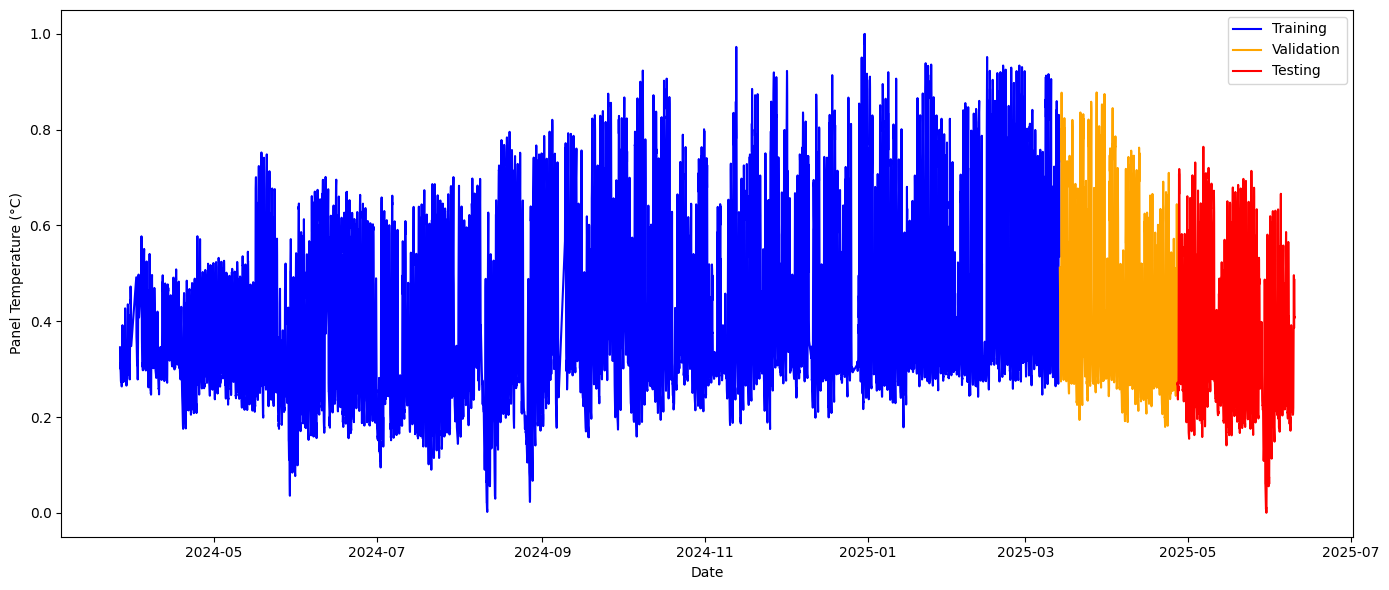

In [24]:
plt.figure(figsize=(14, 6))
plt.plot(training.index, training["panel_temperature_celsius"], label="Training", color="blue")
plt.plot(validation.index, validation["panel_temperature_celsius"], label="Validation", color="orange")
plt.plot(testing.index, testing["panel_temperature_celsius"], label="Testing", color="red")

plt.xlabel("Date")
plt.ylabel("Panel Temperature (°C)")
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
def XY(data,timestep):
    x = []
    y = []
    for i in range(timestep, len(data)):
            x.append(data.iloc[i-timestep:i].values)
            y.append(data.iloc[i, 0])
    return np.array(x),np.array(y)
timestep = 24
x_train, y_train = XY(training, timestep)
x_test, y_test = XY(testing, timestep)
x_val, y_val = XY(validation, timestep)

print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)
print("x_val", x_val.shape)
print("y_val", y_val.shape)

x_train (8429, 24, 6)
y_train (8429,)
x_test (1033, 24, 6)
y_test (1033,)
x_val (1033, 24, 6)
y_val (1033,)


In [26]:
@register_keras_serializable()
class AttentionLayer(Layer): # type: ignore
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.w = self.add_weight(name="att_weight", shape=(input_shape[-1], input_shape[-1]), trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1],), initializer="zeros", trainable=True)
        self.u = self.add_weight(name="att_u", shape=(input_shape[-1],), trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        v = tf.tanh(tf.tensordot(inputs, self.w, axes=1) + self.b)
        vu = tf.tensordot(v, self.u, axes=1)
        alphas = tf.nn.softmax(vu, axis=1)

        entropy = -tf.reduce_sum(alphas * tf.math.log(alphas + 1e-10), axis=1)
        self.add_loss(0.01 * tf.reduce_mean(entropy)) 

        output = tf.reduce_sum(inputs * tf.expand_dims(alphas, -1), axis=1)
        return output, alphas

layer

In [27]:
inputs = Input(shape=(x_train.shape[1], x_train.shape[2])) # type: ignore
x = LSTM(128, return_sequences=True)(inputs) # type: ignore
x = LSTM(256, return_sequences=True)(x) # type: ignore
x = LSTM(256, return_sequences=True)(x) # type: ignore
# x = Bidirectional(LSTM(256, return_sequences=True))(x) # type: ignore
x = Dropout(0.2)(x) # type: ignore
x, attention_weights = AttentionLayer(name="attention_layer")(x)
x = Dense(32, activation='relu')(x) # type: ignore
outputs = Dense(1, activation='linear')(x) # type: ignore
model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 24, 6)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 24, 128)        │        69,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 24, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 24, 256)        │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer                 │ [(None, 256), (None,   │        65,816 │
│ (AttentionLayer)                │ 24)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,062,745 (4.05 MB)

 Trainable params: 1,062,745 (4.05 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
attention_model = Model(inputs=model.input, outputs=model.get_layer("attention_layer").output)

In [29]:
class TimeHistory(Callback):
    def on_train_begin(self, logs=None):
        self.start_time = time.time()
    
    def on_train_end(self, logs=None):
        self.end_time = time.time()
        self.total_time = self.end_time - self.start_time
        print(f"\nTotal training time: {self.total_time:.2f} seconds") 
        
time_callback = TimeHistory()        

modelfit

In [30]:
batch_size = 8
# batch_size = 16
# batch_size = 32
# batch_size = 64
model.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError(), MeanAbsolutePercentageError()])
history = model.fit(x_train, y_train, epochs=50, batch_size=batch_size, validation_data=(x_val, y_val), callbacks=[time_callback])

Epoch 1/50
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 26s 22ms/step - loss: 0.0675 - mean_absolute_percentage_error: 31.0050 - root_mean_squared_error: 0.1786 - val_loss: 0.0260 - val_mean_absolute_percentage_error: 11.0616 - val_root_mean_squared_error: 0.0706
Epoch 2/50
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.0276 - mean_absolute_percentage_error: 29.6860 - root_mean_squared_error: 0.1003 - val_loss: 0.0141 - val_mean_absolute_percentage_error: 10.5359 - val_root_mean_squared_error: 0.0758
Epoch 3/50
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - loss: 0.0152 - mean_absolute_percentage_error: 19.4372 - root_mean_squared_error: 0.0931 - val_loss: 0.0078 - val_mean_absolute_percentage_error: 10.8011 - val_root_mean_squared_error: 0.0751
Epoch 4/50
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - loss: 0.0106 - mean_absolute_percentage_error: 19.6710 - root_mean_squared_error: 0.0939 - val_loss: 0.0049 - val_mean_absolute_percentage_error: 9.7138 - val_root_mean_squared_error: 0.0646
E

In [31]:
final_lr = "{:.3e}".format(model.optimizer.learning_rate.numpy())
elapsed_time = "{:.2f}".format(time_callback.total_time)
final_epoch = len(history.history['loss'])

In [32]:
history_df = pd.DataFrame(history.history)
history_df

,loss,mean_absolute_percentage_error,root_mean_squared_error,val_loss,val_mean_absolute_percentage_error,val_root_mean_squared_error
0,0.046495,26.425188,0.133664,0.026003,11.061624,0.070648
1,0.023699,21.322033,0.096767,0.014106,10.535945,0.075830
2,0.013623,21.224905,0.093493,0.007785,10.801107,0.075124
3,0.009980,21.315813,0.092557,0.004919,9.713778,0.064574
4,0.008770,20.630575,0.089840,0.005493,10.490058,0.069762
5,0.008102,19.809126,0.086701,0.004021,9.043973,0.060084
6,0.007522,18.690771,0.083344,0.004267,9.336760,0.062657
7,0.006633,17.656666,0.077558,0.003035,7.243006,0.049505
8,0.005854,16.179722,0.071897,0.003002,6.911530,0.047679
9,0.005086,14.671162,0.066031,0.003956,9.336492,0.056419


In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error
pred = model.predict(x_test).flatten()
actual = y_test

index = df.columns.get_loc('panel_temperature_celsius')
copy_pred = np.zeros((len(pred), len(df.columns)))
copy_actual = np.zeros((len(actual), len(df.columns)))
copy_pred[:, index] = pred
copy_actual[:, index] = actual
pred_inverse = scaler.inverse_transform(copy_pred)[:, index]
actual_inverse = scaler.inverse_transform(copy_actual)[:, index]

loss, rmse, mape = model.evaluate(x_test, y_test, verbose=0)
r2 = r2_score(actual_inverse, pred_inverse)
mape_scikit = mean_absolute_percentage_error(actual_inverse, pred_inverse)

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


In [34]:
tgl = df.index[-len(pred_inverse):] 
tabel_prediksi = pd.DataFrame({
    'Tanggal': tgl,
    'Aktual': actual_inverse,
    'Prediksi': pred_inverse
})

tabel_prediksi.set_index('Tanggal', inplace=True)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print(tabel_prediksi)

                              Aktual   Prediksi
Tanggal                                        
2025-04-27 23:00:00+00:00  30.534305  30.846042
2025-04-28 00:00:00+00:00  29.694144  29.819721
2025-04-28 01:00:00+00:00  29.661757  28.900876
2025-04-28 02:00:00+00:00  30.181574  28.706840
2025-04-28 03:00:00+00:00  28.737387  28.788092
2025-04-28 04:00:00+00:00  28.249481  27.705618
2025-04-28 05:00:00+00:00  27.907944  27.366874
2025-04-28 06:00:00+00:00  27.324216  27.359237
2025-04-28 07:00:00+00:00  26.973806  27.404935
2025-04-28 08:00:00+00:00  27.038978  27.467237
2025-04-28 09:00:00+00:00  26.302897  27.850303
2025-04-28 10:00:00+00:00  27.328900  28.639501
2025-04-28 11:00:00+00:00  27.025966  31.345212
2025-04-28 12:00:00+00:00  27.109033  30.200317
2025-04-28 13:00:00+00:00  29.410932  31.241456
2025-04-28 14:00:00+00:00  29.683864  33.352047
2025-04-28 15:00:00+00:00  32.671165  31.114531
2025-04-28 16:00:00+00:00  34.256851  38.576637
2025-04-28 17:00:00+00:00  35.066979  36

hasil

In [35]:
print("Loss:", loss)
print("RMSE:", rmse)
print("R2 Score:", r2)
print("MAPE:", mape)
print("MAPE_scikit:", mape_scikit*100)
print("Elapsed Time (s):", elapsed_time)

Loss: 0.0009591456619091332
RMSE: 0.028032483533024788
R2 Score: 0.96065821442767
MAPE: 57040.296875
MAPE_scikit: 4.93276668144427
Elapsed Time (s): 1133.55


In [36]:
layer_units = []
for layer in model.layers:
    if hasattr(layer, "units"):
        layer_units.append(str(layer.units))
conf_text = "-".join(layer_units)

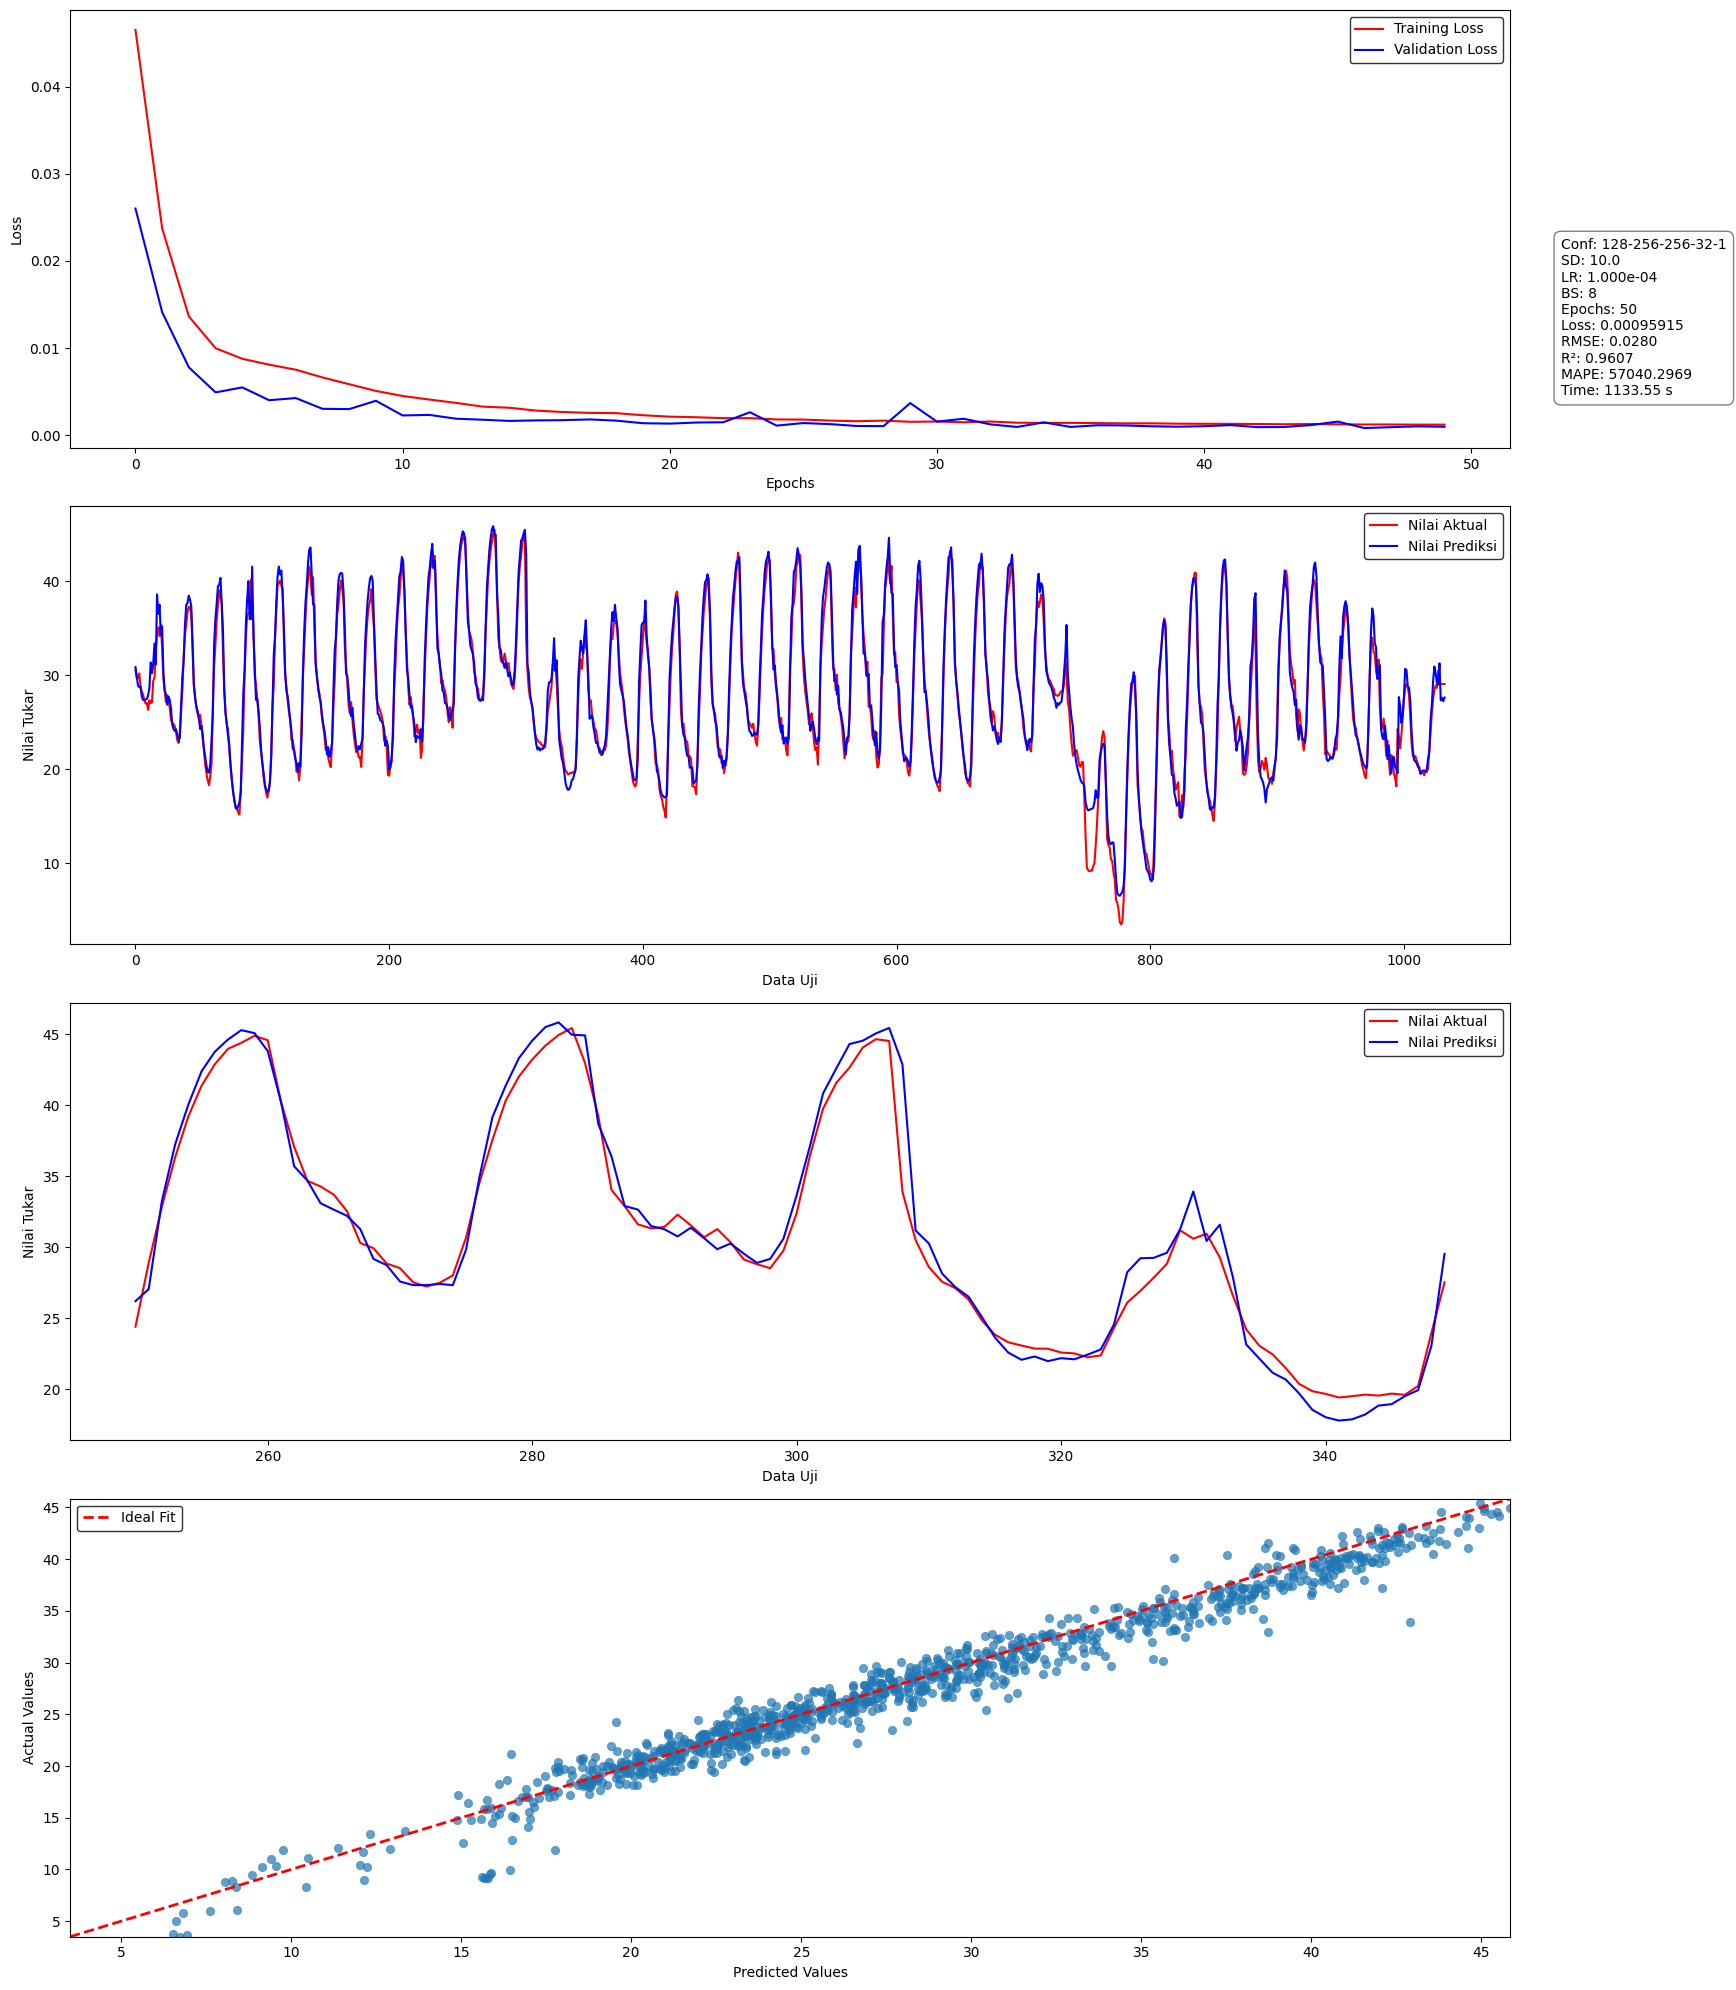

In [37]:
plt.rcParams.update({
    'axes.facecolor': 'white', 
    'figure.facecolor': 'white', 
    'axes.edgecolor': 'black',   
    'axes.labelcolor': 'black',  
    'xtick.color': 'black',     
    'ytick.color': 'black',     
    'text.color': 'black',      
    'legend.edgecolor': 'black',
})

plt.figure(figsize=(18, 20))

plt.subplot(4, 1, 1)
plt.plot(history_df['loss'], label='Training Loss', color='red')
plt.plot(history_df['val_loss'], label='Validation Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best', facecolor='white')

plt.subplot(4, 1, 2)
plt.plot(actual_inverse, color='red', label='Nilai Aktual')
plt.plot(pred_inverse, color='blue', label='Nilai Prediksi')
plt.xlabel('Data Uji')
plt.ylabel('Nilai Tukar')
plt.legend(facecolor='white')

plt.subplot(4, 1, 3)
plt.plot(range(250, 350), actual_inverse[250:350], color='red', label='Nilai Aktual')
plt.plot(range(250, 350), pred_inverse[250:350], color='blue', label='Nilai Prediksi')
plt.xlabel('Data Uji')
plt.ylabel('Nilai Tukar')
plt.legend(facecolor='white')

plt.subplot(4, 1, 4)
sns.scatterplot(x=np.ravel(pred_inverse), y=np.ravel(actual_inverse), alpha=0.7, edgecolor=None)
min_val = min(np.min(pred_inverse), np.min(actual_inverse))
max_val = max(np.max(pred_inverse), np.max(actual_inverse))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label="Ideal Fit")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.xlim([min_val, max_val])
plt.ylim([min_val, max_val])
plt.legend(facecolor='white')

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.figtext(
    0.87, 0.8, 
    f'Conf: {conf_text}\nSD: {test_ratio*100}\nLR: {final_lr}\nBS: {batch_size}\nEpochs: {final_epoch}\nLoss: {loss:.8f}\nRMSE: {rmse:.4f}\nR²: {r2:.4f}\nMAPE: {mape:.4f}\nTime: {elapsed_time} s',
    fontsize=10,
    bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.5'),
    ha='left',
    color='black'
)

plt.show()
